# **Book Recommendation System**

## **1. Overview**

### 1.1 Data
There are 3 datasets:
- **Books**: contains book information including book title, author, publication year, and publisher.
- **Users**: contains user information including user ID, user location and age if available.
- **Ratings**: contains book rating which is expressed on a scale of 1-10 with higher value indicates higher appreciation.
### 1.2 Objective
- Perform EDA to gain insights into the datasets.
- Create algorithm to reccomend book to users.



## **2. Prepare Data**

In [99]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### 2.1 Books Dataset

In [100]:
# Load data
books = pd.read_csv("Books.csv", usecols=[0,1,2,3,4])

# Inspect data
books.head()

c:\Users\Phuong\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [101]:
# Data info
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


Notice that column year-of-publication is of object type, which should be converted to integer type.

There are some null values but we will leave it as it is.

In [102]:
# Convert year of publication to integer
book = books.copy()
# Cooerce the conversion will return NaN value if value cannot be converted into numerical value
book['Year-Of-Publication'] = pd.to_numeric(book['Year-Of-Publication'], errors='coerce')

# Find all the rows that year of publication is not an integer
books[book['Year-Of-Publication'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


There are 3 data points where the values of book author, year of publication and publisher are mismatched.\
To fix this, we move the value from book author to year of publication and year of publication to publisher. Also, the author name is concatenated at the end of the book-title so we will extract this information and put it in the correct column.

In [103]:
mask = books['Year-Of-Publication'].isin(['DK Publishing Inc','Gallimard'])

# Extract the book-author from book-title
authors = []
titles = []
for title in books.loc[mask,'Book-Title']:  
    author = title.split(';')[-1].split('"')[0]
    book_title = title.split(';')[0].split('\\')[0]

    authors.append(author)
    titles.append(book_title)

# Switch the values
books.loc[mask, ['Year-Of-Publication', 'Publisher']] = books.loc[mask, ['Book-Author', 'Year-Of-Publication']].values
books.loc[mask, 'Book-Author']  = authors
books.loc[mask, 'Book-Title'] = titles

# Convert Year Of Publication column to integer type
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'])

books[books['ISBN'].isin(['078946697X','2070426769','0789466953'])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


### 2.2 Users Dataset

In [104]:
# Load data
users = pd.read_csv("Users.csv")

# Inpsect data
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [105]:
# Users info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


There are 110762 missing values in age column out of 278858 values. Since we will use content-based filtering based on book information so we can leave the missing value as it is.

### 2.3 Ratings Dataset


In [106]:
# Load data
ratings = pd.read_csv("Ratings.csv")

# Inpsect data
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [107]:
# Ratings info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [108]:
# Confirm that every user id in ratings dataset also exist in user dataset
len(ratings[~ratings['User-ID'].isin(users['User-ID'])]['User-ID'].unique()) == 0

True

## **3. Exploratory Data Analysis (EDA)**

In [109]:
# Find number of ratings and average rating per each book
ratings_count = ratings.groupby('ISBN').count()[['User-ID']].rename(columns={'User-ID': 'Num Ratings'})
avg_rating = ratings.groupby('ISBN')['Book-Rating'].mean().rename('Avg Rating')
book_with_ratings = books.merge(ratings_count, on='ISBN').merge(avg_rating, on='ISBN')
book_with_ratings.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Num Ratings,Avg Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,1,0.000000
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,14,4.928571
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,3,5.000000
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,11,4.272727
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,1,0.000000


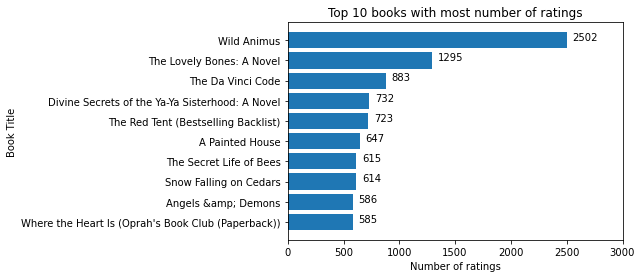

In [110]:
# Top 10 books with most ratings
top_10_most_ratings = book_with_ratings.nlargest(10, 'Num Ratings')
plt.barh(top_10_most_ratings['Book-Title'], top_10_most_ratings['Num Ratings'])
plt.gca().invert_yaxis()
plt.xlabel('Number of ratings')
plt.ylabel('Book Title')
plt.title('Top 10 books with most number of ratings')
plt.gca().set_xlim([0, 3000])

for i, v in enumerate(top_10_most_ratings['Num Ratings']):
    plt.text(v + 50, i, str(v), color='black')
    
plt.show()

To find books with highest ratings, we need to consider that a book can be rated highly but only have 1 or 2 readers rating it. To address this issue, we will introduce a weighted rating score (Bayesian average) which can be computed as:

Weighted rating score = $(v/(v+m)) * R + (m/ (v+m)) * C$

where
* R = average rating of the book
* v = number of ratings of the book
* m = minimum number of ratings required for book to be considered (10 for this case)
* C = average rating across all books in the dataset

In [111]:
# Caclulate average rating across all books
avg_ratings = ratings['Book-Rating'].mean()

# Caculate the weighted rating score for each book
m = 10
book_with_ratings['Score'] = (book_with_ratings['Num Ratings'] / (book_with_ratings['Num Ratings'] + m)) * book_with_ratings['Avg Rating'] + (m / (book_with_ratings['Num Ratings'] + m)) * avg_ratings


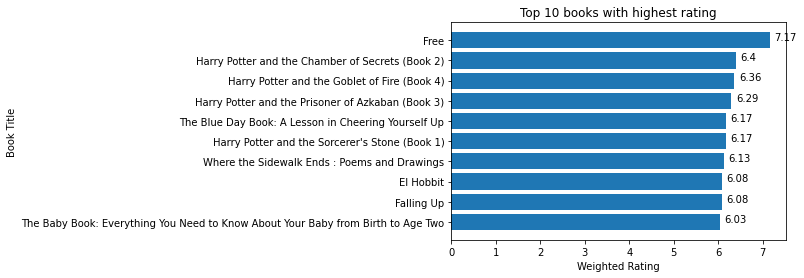

In [112]:
# Top 10 books with highest weighted rating score
top_10_highest_ratings = book_with_ratings.nlargest(10, 'Score')
plt.barh(top_10_highest_ratings['Book-Title'], top_10_highest_ratings['Score'])
plt.gca().invert_yaxis()
plt.xlabel('Weighted Rating')
plt.ylabel('Book Title')
plt.title('Top 10 books with highest rating')

for i, v in enumerate(top_10_highest_ratings['Score']):
    plt.text(v + 0.1, i, str(round(v,2)), color='black')
    
plt.show()

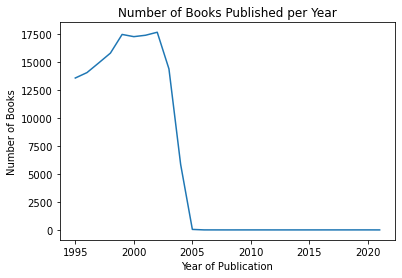

In [113]:
# Relationship between year published and number of books published
# Filter the books dataset to consider only books published between 1995 and 2023
filtered_year = books[books['Year-Of-Publication'].between(1995, 2023)]

# Group the filtered books by publication year and count the number of books
book_counts = filtered_year.groupby('Year-Of-Publication').count()

# Plot the line chart
plt.plot(book_counts.index, book_counts['ISBN'])
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')
plt.title('Number of Books Published per Year')

plt.show()

No trend or pattern identified between the year of publication and number of books published.

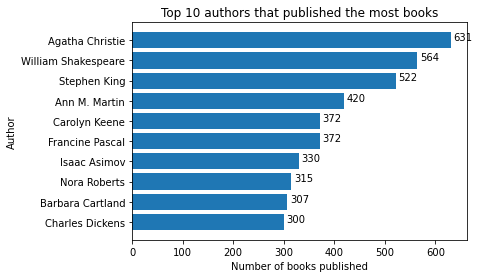

In [114]:
author_stats = book_with_ratings.groupby('Book-Author').agg(
    Num_Books=('ISBN', 'count'),
    Avg_Rating=('Avg Rating', 'mean'),
    Avg_Score=('Score', 'mean')
).reset_index()

# Top 10 author that published the most books
top_10_author = author_stats.nlargest(10, 'Num_Books')
plt.barh(top_10_author['Book-Author'], top_10_author['Num_Books'])
plt.gca().invert_yaxis()
plt.xlabel('Number of books published')
plt.ylabel('Author')
plt.title('Top 10 authors that published the most books')

for i, v in enumerate(top_10_author['Num_Books']):
    plt.text(v + 5, i, str(v), color='black')
    
plt.show()



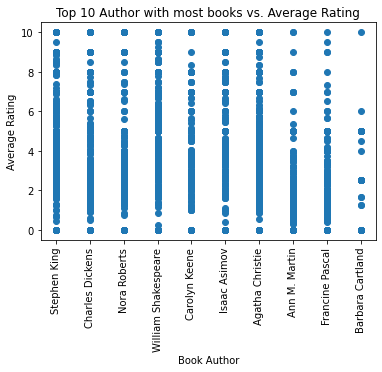

In [115]:
# Find correlation between top authors and ratings
filtered_author_rating = book_with_ratings[book_with_ratings['Book-Author'].isin(top_10_author['Book-Author'])]

plt.scatter(filtered_author_rating['Book-Author'], filtered_author_rating['Avg Rating'])
plt.xlabel('Book Author')
plt.ylabel('Average Rating')
plt.title('Top 10 Author with most books vs. Average Rating')
plt.xticks(rotation=90)
plt.show()

There is no correlation between top 10 authors that published the most books and their book ratings.

### **4. Recommendation System**